![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

max_depth: 1 Accuracy: 0.858256351039261
max_depth: 2 Accuracy: 0.858256351039261
max_depth: 3 Accuracy: 0.8778868360277137
max_depth: 4 Accuracy: 0.8810623556581986
max_depth: 5 Accuracy: 0.8879907621247113
max_depth: 6 Accuracy: 0.8830831408775982
max_depth: 7 Accuracy: 0.8827944572748267
max_depth: 8 Accuracy: 0.8784642032332564
max_depth: 9 Accuracy: 0.8755773672055427
max_depth: 10 Accuracy: 0.8755773672055427


Text(0, 0.5, 'Accuracy')

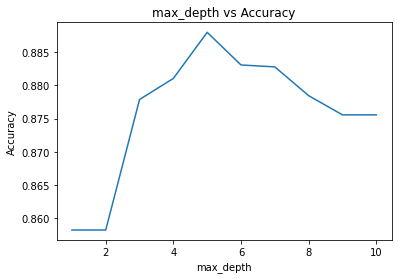

In [5]:
# Celda 1
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)


# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 11)

# Lista para guardar los valores del Accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Entrenamiento del árbol de decisión manual
    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=depth, num_pct=10)
    
    # Predicción del arbol con los datos de test
    y_pred = tree_predict(X_test, tree)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print('max_depth:', depth, 'Accuracy:', accuracy)

# Gráfica max_depth versus accuracy (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Se realiza el arbol de decisión manual con diferentes valores de max_depth logrando un Accuracy de 0.8582 con un max_depth de 1 y obteniendo el mejor Accuracy de 0.8879 con un max_depth de 5 tal como se puede apreciar en la gráfica.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

Bagging manual con max_depth: 1 Accuracy: 0.8481524249422633
Bagging manual con max_depth: 2 Accuracy: 0.8674942263279446
Bagging manual con max_depth: 3 Accuracy: 0.8799076212471132
Bagging manual con max_depth: 4 Accuracy: 0.8767321016166282
Bagging manual con max_depth: 5 Accuracy: 0.8885681293302541
Bagging manual con max_depth: 6 Accuracy: 0.8874133949191686
Bagging manual con max_depth: 7 Accuracy: 0.8851039260969977
Bagging manual con max_depth: 8 Accuracy: 0.8842378752886836
Bagging manual con max_depth: 9 Accuracy: 0.8845265588914549
Bagging manual con max_depth: 10 Accuracy: 0.8851039260969977


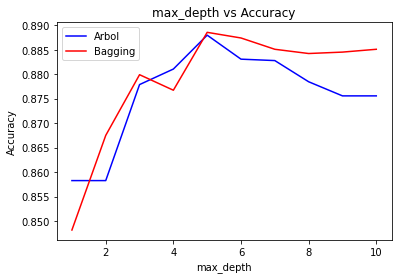

In [6]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

# Lista para guardar los valores del Accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores_bag = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
  # DataFrame para guardar las predicciones de cada árbol
  y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

  # Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
  for i, sample in enumerate(samples):
    X_train_b = X_train.iloc[sample]
    y_train_b = y_train.iloc[sample]
    #treeclf.fit(X_train_b, y_train_b)
    treebag = tree_grow(X_train_b, y_train_b, level=0, min_gain=0.001, max_depth=depth, num_pct=10)
    #y_pred.iloc[:,i] = treeclf.predict(X_test)
    y_pred.iloc[:,i] = tree_predict(X_test, treebag)

  # Votación mayoritaria
  y_pred_vot = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_vot)
  accuracy_scores_bag.append(accuracy)
  print('Bagging manual con max_depth:', depth, 'Accuracy:', accuracy)


# Gráfica max_depth versus accuracy (error del modelo)
plt.plot(max_depth_range, accuracy_scores, color="blue", label="Arbol")
plt.plot(max_depth_range, accuracy_scores_bag, color="red", label="Bagging")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

Se realiza un modelo de Bagging manual con 10 árboles, incrementando los max_depth de 1 a 10 y al realizar la gráfica comparativa se observa que en general el modelo de Bagging brinda mejores resultados de Accuracy que el modelo de Arbol, ya que el bootstrap utilizado en Bagging reduce la varianza de los datos mejorando la predicción.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

Bagging libreria con max_depth: 1 Accuracy: 0.8669168591224018
Bagging libreria con max_depth: 2 Accuracy: 0.8695150115473441
Bagging libreria con max_depth: 3 Accuracy: 0.871824480369515
Bagging libreria con max_depth: 4 Accuracy: 0.878175519630485
Bagging libreria con max_depth: 5 Accuracy: 0.878175519630485
Bagging libreria con max_depth: 6 Accuracy: 0.8801963048498845
Bagging libreria con max_depth: 7 Accuracy: 0.8778868360277137
Bagging libreria con max_depth: 8 Accuracy: 0.8784642032332564
Bagging libreria con max_depth: 9 Accuracy: 0.8764434180138568
Bagging libreria con max_depth: 10 Accuracy: 0.875


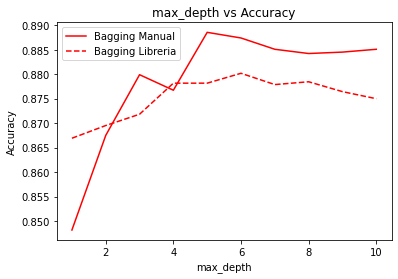

In [7]:
# Celda 3
# Define max_features
max_features = np.int(np.log2(X_train.shape[1]))

# Lista para guardar los valores del Accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores_baglib = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
  # Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
  bagclf = BaggingClassifier(DecisionTreeClassifier(max_depth=depth, random_state=1), n_estimators=10, max_features=max_features,
                             bootstrap=True, oob_score=True, random_state=1)

  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  bagclf.fit(X_train, y_train)
  y_pred_baglib = bagclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_baglib)
  accuracy_scores_baglib.append(accuracy)
  print('Bagging libreria con max_depth:', depth, 'Accuracy:', accuracy)

# Gráfica max_depth versus accuracy (error del modelo)
plt.plot(max_depth_range, accuracy_scores_bag, color="red", label="Bagging Manual")
plt.plot(max_depth_range, accuracy_scores_baglib, color="red", linestyle='--', label="Bagging Libreria")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

Se realiza un modelo de Bagging con la libreria BaggingClassifier, con 10 árboles, se calcula max_features con logaritmo en base 2 de los predictores en X_train obteniendo el valor de 3 para max_features, se van incrementando los max_depth de 1 a 10 y al realizar la gráfica comparativa se observa que en general el modelo de Bagging con libreria brinda resultados inferiores de Accuracy que el modelo de Bagging manual como consecuencia de haber restingido el max_features, ya que al verificar sin dicha restricción el modelo genera unos resultados mejores.



### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

Random Forest con max_depth: 1 Accuracy: 0.8452655889145496
Random Forest con max_depth: 2 Accuracy: 0.8692263279445728
Random Forest con max_depth: 3 Accuracy: 0.8764434180138568
Random Forest con max_depth: 4 Accuracy: 0.8819284064665127
Random Forest con max_depth: 5 Accuracy: 0.8830831408775982
Random Forest con max_depth: 6 Accuracy: 0.8874133949191686
Random Forest con max_depth: 7 Accuracy: 0.8865473441108545
Random Forest con max_depth: 8 Accuracy: 0.8848152424942263
Random Forest con max_depth: 9 Accuracy: 0.8804849884526559
Random Forest con max_depth: 10 Accuracy: 0.8778868360277137


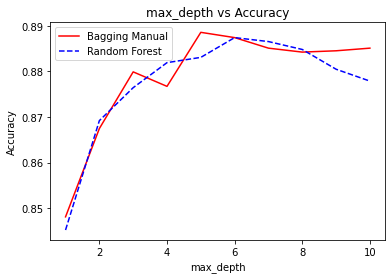

In [8]:
# Celda 4
# Lista para guardar los valores del Accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores_rf = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
  rfclf = RandomForestClassifier(max_depth=depth, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  rfclf.fit(X_train, y_train)
  y_pred_rf = rfclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_rf.append(accuracy)
  print('Random Forest con max_depth:', depth, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, accuracy_scores_bag, color="red", label="Bagging Manual")
plt.plot(max_depth_range, accuracy_scores_rf, color='blue', linestyle='--', label="Random Forest")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

Se realiza un modelo de Random Forest con la libreria RandomForestClassifier, con parámetros por defecto, incrementando los max_depth de 1 a 10 y al realizar la gráfica comparativa se observa que en general el modelo de Random Forest brinda resultados de Accuracy cercanos a los del modelo de Bagging manual.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

Random Forest con max_depth: 1 Accuracy: 0.8452655889145496
Random Forest con max_depth: 2 Accuracy: 0.8692263279445728
Random Forest con max_depth: 3 Accuracy: 0.8764434180138568
Random Forest con max_depth: 4 Accuracy: 0.8819284064665127
Random Forest con max_depth: 5 Accuracy: 0.8830831408775982
Random Forest con max_depth: 6 Accuracy: 0.8874133949191686
Random Forest con max_depth: 7 Accuracy: 0.8865473441108545
Random Forest con max_depth: 8 Accuracy: 0.8848152424942263
Random Forest con max_depth: 9 Accuracy: 0.8804849884526559
Random Forest con max_depth: 10 Accuracy: 0.8778868360277137


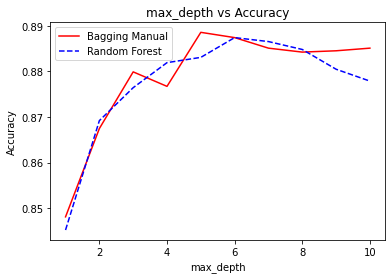

In [9]:
# Celda 5
# Calibración de max_depth
# Lista para guardar los valores del Accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores_rf = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
  rfclf = RandomForestClassifier(max_depth=depth, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  rfclf.fit(X_train, y_train)
  y_pred_rf = rfclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_rf.append(accuracy)
  print('Random Forest con max_depth:', depth, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, accuracy_scores_bag, color="red", label="Bagging Manual")
plt.plot(max_depth_range, accuracy_scores_rf, color='blue', linestyle='--', label="Random Forest")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

Random Forest con max_features: 1 Accuracy: 0.8827944572748267
Random Forest con max_features: 2 Accuracy: 0.8845265588914549
Random Forest con max_features: 3 Accuracy: 0.8874133949191686
Random Forest con max_features: 4 Accuracy: 0.8868360277136259
Random Forest con max_features: 5 Accuracy: 0.8879907621247113
Random Forest con max_features: 6 Accuracy: 0.8879907621247113
Random Forest con max_features: 7 Accuracy: 0.8888568129330254
Random Forest con max_features: 8 Accuracy: 0.8879907621247113
Random Forest con max_features: 9 Accuracy: 0.8882794457274826


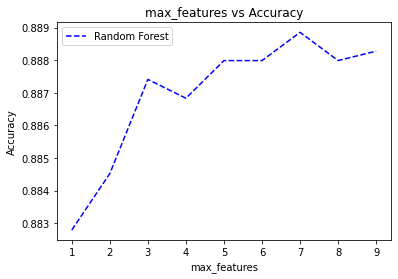

In [10]:
# Calibración de max_fetures utilizando el mejor max_depth del punto anterior
# Definición de lista para almacenar la exactitud (accuracy) para cada valor de max_features
accuracy_scores_rff = []

# Define max_features_range
max_features_range = range(1, X_train.shape[1] + 1)

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for features in max_features_range:
  rfclf = RandomForestClassifier(max_features=features, max_depth=6, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  rfclf.fit(X_train, y_train)
  y_pred_rf = rfclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_rff.append(accuracy)
  print('Random Forest con max_features:', features, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(max_features_range, accuracy_scores_rff, color='blue', linestyle='--', label="Random Forest")
plt.title('max_features vs Accuracy')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.legend()

Random Forest con n_estimators: 10 Accuracy: 0.8879907621247113
Random Forest con n_estimators: 20 Accuracy: 0.8879907621247113
Random Forest con n_estimators: 30 Accuracy: 0.8885681293302541
Random Forest con n_estimators: 40 Accuracy: 0.8877020785219399
Random Forest con n_estimators: 50 Accuracy: 0.8885681293302541
Random Forest con n_estimators: 60 Accuracy: 0.8879907621247113
Random Forest con n_estimators: 70 Accuracy: 0.8888568129330254
Random Forest con n_estimators: 80 Accuracy: 0.8882794457274826
Random Forest con n_estimators: 90 Accuracy: 0.8885681293302541
Random Forest con n_estimators: 100 Accuracy: 0.8888568129330254
Random Forest con n_estimators: 110 Accuracy: 0.8888568129330254
Random Forest con n_estimators: 120 Accuracy: 0.8885681293302541
Random Forest con n_estimators: 130 Accuracy: 0.8885681293302541
Random Forest con n_estimators: 140 Accuracy: 0.8894341801385681
Random Forest con n_estimators: 150 Accuracy: 0.8891454965357968
Random Forest con n_estimators: 16

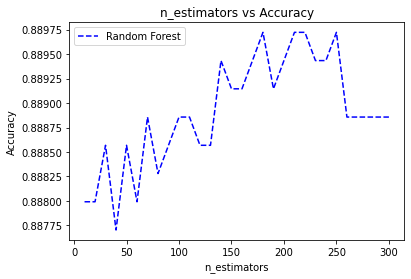

In [20]:
# Calibración de n_estimators utilizando los mejores max_depth y max_features del punto anterior
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) para cada valor de n_estimators
accuracy_scores_rfe = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
  rfclf = RandomForestClassifier(n_estimators=estimator, max_features=7, max_depth=6, random_state=1, n_jobs=-1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  rfclf.fit(X_train, y_train)
  y_pred_rf = rfclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_rfe.append(accuracy)
  print('Random Forest con n_estimators:', estimator, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_rfe, color='blue', linestyle='--', label="Random Forest")
plt.title('n_estimators vs Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()

Random Forest con max_depth: 1 Accuracy: 0.8596997690531177
Random Forest con max_depth: 2 Accuracy: 0.8712471131639723
Random Forest con max_depth: 3 Accuracy: 0.8787528868360277
Random Forest con max_depth: 4 Accuracy: 0.8839491916859122
Random Forest con max_depth: 5 Accuracy: 0.8888568129330254
Random Forest con max_depth: 6 Accuracy: 0.8897228637413395
Random Forest con max_depth: 7 Accuracy: 0.8865473441108545
Random Forest con max_depth: 8 Accuracy: 0.8830831408775982
Random Forest con max_depth: 9 Accuracy: 0.8807736720554272
Random Forest con max_depth: 10 Accuracy: 0.8761547344110855


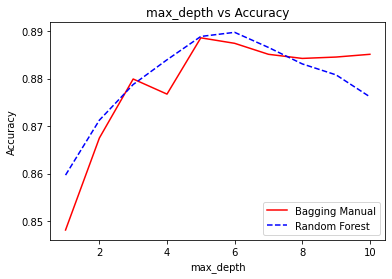

In [28]:
# Calibración de max_depth con los mejores max_fetures y n_estimators del punto anterior
# Definición de lista para almacenar la exactitud (accuracy) para cada valor de max_depth
accuracy_scores_rfd = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in max_depth_range:
  rfclf = RandomForestClassifier(max_depth=depth, n_estimators=180, max_features=7, random_state=1, n_jobs=-1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  rfclf.fit(X_train, y_train)
  y_pred_rf = rfclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_rfd.append(accuracy)
  print('Random Forest con max_depth:', depth, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, accuracy_scores_bag, color="red", label="Bagging Manual")
plt.plot(max_depth_range, accuracy_scores_rfd, color='blue', linestyle='--', label="Random Forest")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

Se realiza un modelo de Random Forest con la libreria RandomForestClassifier, con parámetros por defecto, incrementando los max_depth de 1 a 10 obteniendo con el valor 6 el mejor Accuracy de 0.8874 y al realizar la gráfica comparativa se observa que en general el modelo de Random Forest brinda resultados de Accuracy cercanos a los del modelo de Bagging manual.

Se realiza un modelo de Random Forest con max_depth de 6, incrementando los max_fetures de 1 al total de features de X_train que es de 9, obteniedo con el valor 7 el mejor Accuracy de 0.8888, por lo que el modelo mejora con un valor menor del total variables predictoras.

Se realiza un modelo de Random Forest con max_depth de 6, max_fetures de 7, incrementando los n_estimators de 10 a 300 obteniedo que en la medida que aumentan los estimadores el desempeño del modelo mejora hasta llegar al valor de 180 estimadores en el que deja de mejorar y se logra el mejor Accuracy 0.8897.

Se realiza un modelo de Random Forest con max_features de 7, n_estimators de 180, incrementando los max_depth de 1 a 10 y al realizar la gráfica comparativa se observa que en general el modelo de Random Forest calibrado brinda mejores resultados de Accuracy que el modelo de Bagging manual.

En conclusión al calibrar cada parámetro el modelo tiende a mejorar en su resultado de Accuracy.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

XGBoost con max_depth: 1 Accuracy: 0.8825057736720554
XGBoost con max_depth: 2 Accuracy: 0.8865473441108545
XGBoost con max_depth: 3 Accuracy: 0.8877020785219399
XGBoost con max_depth: 4 Accuracy: 0.8856812933025404
XGBoost con max_depth: 5 Accuracy: 0.8865473441108545
XGBoost con max_depth: 6 Accuracy: 0.8877020785219399
XGBoost con max_depth: 7 Accuracy: 0.8856812933025404
XGBoost con max_depth: 8 Accuracy: 0.8845265588914549
XGBoost con max_depth: 9 Accuracy: 0.8822170900692841
XGBoost con max_depth: 10 Accuracy: 0.8842378752886836


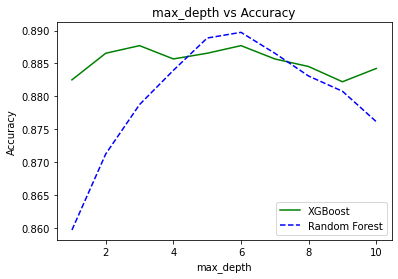

In [13]:
# Celda 6
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_xg = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
  xgclf = XGBClassifier(max_depth=depth, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  xgclf.fit(X_train, y_train)
  y_pred_rf = xgclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_xg.append(accuracy)
  print('XGBoost con max_depth:', depth, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, accuracy_scores_xg, color="green", label="XGBoost")
plt.plot(max_depth_range, accuracy_scores_rfd, color='blue', linestyle='--', label="Random Forest")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

Se realiza un modelo de XGBoost con la libreria XGBClassifier, con parámetros por defecto, incrementando los max_depth de 1 a 10 y al realizar la gráfica comparativa se observa que en general el modelo de XGBoost brinda desde el comienzo resultados de Accuracy superiores a 0.8822 pero en los max_depth 5, 6 y 7 es superado por el modelo de Random Forest calibrado del punto anterior.

En la gráfica se puede apreciar que el modelo XGBoost aprende más rapidamente que el modelo de Random Forest.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

XGBoost con learning_rate: 0.0001 Accuracy: 0.8807736720554272
XGBoost con learning_rate: 0.001 Accuracy: 0.8807736720554272
XGBoost con learning_rate: 0.01 Accuracy: 0.875866050808314
XGBoost con learning_rate: 0.05 Accuracy: 0.8845265588914549
XGBoost con learning_rate: 0.1 Accuracy: 0.8877020785219399
XGBoost con learning_rate: 0.15 Accuracy: 0.8865473441108545
XGBoost con learning_rate: 0.2 Accuracy: 0.8862586605080831
XGBoost con learning_rate: 0.3 Accuracy: 0.8871247113163973
XGBoost con learning_rate: 0.4 Accuracy: 0.8839491916859122
XGBoost con learning_rate: 0.5 Accuracy: 0.8819284064665127


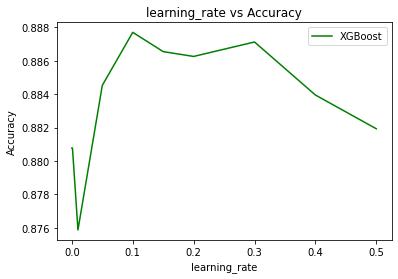

In [14]:
# Celda 7
# Calibración de learning_rate
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de learning_rate
accuracy_scores_xgl = []

# Creación de lista de valores para iterar sobre diferentes valores de learning_rate
learning_rate_range = [0.0001, 0.001, 0.01,  0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for rate in learning_rate_range:
  xgclf = XGBClassifier(learning_rate=rate, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  xgclf.fit(X_train, y_train)
  y_pred_rf = xgclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_xgl.append(accuracy)
  print('XGBoost con learning_rate:', rate, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de learning_rate
plt.plot(learning_rate_range, accuracy_scores_xgl, color="green", label="XGBoost")
plt.title('learning_rate vs Accuracy')
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')
plt.legend()

XGBoost con colsample_bytree: 0 Accuracy: 0.8793302540415704
XGBoost con colsample_bytree: 0.1 Accuracy: 0.8793302540415704
XGBoost con colsample_bytree: 0.2 Accuracy: 0.8793302540415704
XGBoost con colsample_bytree: 0.3 Accuracy: 0.8842378752886836
XGBoost con colsample_bytree: 0.4 Accuracy: 0.8871247113163973
XGBoost con colsample_bytree: 0.5 Accuracy: 0.8865473441108545
XGBoost con colsample_bytree: 0.6 Accuracy: 0.8879907621247113
XGBoost con colsample_bytree: 0.7 Accuracy: 0.8879907621247113
XGBoost con colsample_bytree: 0.8 Accuracy: 0.8868360277136259
XGBoost con colsample_bytree: 0.9 Accuracy: 0.8868360277136259
XGBoost con colsample_bytree: 1 Accuracy: 0.8877020785219399


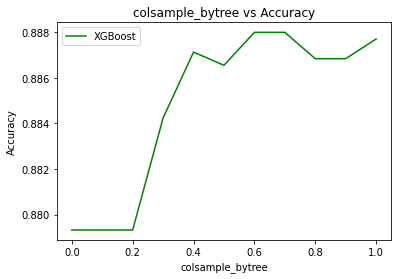

In [15]:
# Calibración de colsample_bytree
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de colsample_bytree
accuracy_scores_xgc = []

# Creación de lista de valores para iterar sobre diferentes valores de gamma
colsample_bytree_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for colsample in colsample_bytree_range:
  xgclf = XGBClassifier(colsample_bytree=colsample, learning_rate=0.1, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  xgclf.fit(X_train, y_train)
  y_pred_rf = xgclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_xgc.append(accuracy)
  print('XGBoost con colsample_bytree:', colsample, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de colsample_bytree
plt.plot(colsample_bytree_range, accuracy_scores_xgc, color="green", label="XGBoost")
plt.title('colsample_bytree vs Accuracy')
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')
plt.legend()

XGBoost con gamma: 0 Accuracy: 0.8879907621247113
XGBoost con gamma: 1 Accuracy: 0.8877020785219399
XGBoost con gamma: 10 Accuracy: 0.8885681293302541
XGBoost con gamma: 15 Accuracy: 0.8903002309468823
XGBoost con gamma: 20 Accuracy: 0.8900115473441108
XGBoost con gamma: 25 Accuracy: 0.8903002309468823
XGBoost con gamma: 30 Accuracy: 0.8891454965357968


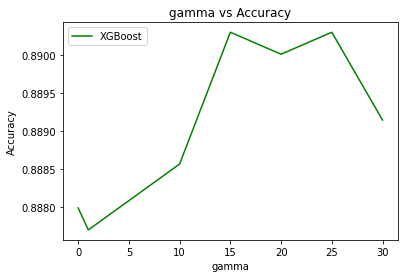

In [35]:
# Calibración de gamma
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de gamma
accuracy_scores_xgg = []

# Creación de lista de valores para iterar sobre diferentes valores de gamma
gamma_range = [0, 1, 10, 15, 20, 25, 30]

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for gamma in gamma_range:
  xgclf = XGBClassifier(gamma=gamma, colsample_bytree=0.7, learning_rate=0.1, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  xgclf.fit(X_train, y_train)
  y_pred_rf = xgclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_xgg.append(accuracy)
  print('XGBoost con gamma:', gamma, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de gamma
plt.plot(gamma_range, accuracy_scores_xgg, color="green", label="XGBoost")
plt.title('gamma vs Accuracy')
plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.legend()

XGBoost con max_depth: 1 Accuracy: 0.8830831408775982
XGBoost con max_depth: 2 Accuracy: 0.8865473441108545
XGBoost con max_depth: 3 Accuracy: 0.8903002309468823
XGBoost con max_depth: 4 Accuracy: 0.8905889145496536
XGBoost con max_depth: 5 Accuracy: 0.8903002309468823
XGBoost con max_depth: 6 Accuracy: 0.8903002309468823
XGBoost con max_depth: 7 Accuracy: 0.8903002309468823
XGBoost con max_depth: 8 Accuracy: 0.8903002309468823
XGBoost con max_depth: 9 Accuracy: 0.8903002309468823
XGBoost con max_depth: 10 Accuracy: 0.8903002309468823


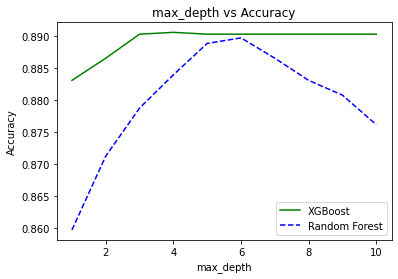

In [39]:
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_xg = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
  xgclf = XGBClassifier(max_depth=depth, colsample_bytree=0.7, gamma=25, learning_rate=0.1, random_state=1)
  
  # Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  xgclf.fit(X_train, y_train)
  y_pred_rf = xgclf.predict(X_test)

  # Desempeño al hacer votación mayoritaria
  accuracy = accuracy_score(y_test, y_pred_rf)
  accuracy_scores_xg.append(accuracy)
  print('XGBoost con max_depth:', depth, 'Accuracy:', accuracy)

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, accuracy_scores_xg, color="green", label="XGBoost")
plt.plot(max_depth_range, accuracy_scores_rfd, color='blue', linestyle='--', label="Random Forest")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

Se realiza un modelo de XGBoost con la libreria XGBClassifier, incrementando los learning_rate de 0.0001 a 0.5 obteniendo con el valor 0.1 el mejor Accuracy de 0.8877, con lo que se evidencia que con una tasa de aprendizaje baja se obtienen mejores resultados de Accuracy tal como se evidencia en la gráfica respectiva. 

Se realiza un modelo de XGBoost con learning_rate de 0.1, incrementando los colsample_bytree de 0 a 1 obteniedo con los valores 0.6 y 0.7 el mejor Accuracy de 0.8879, con lo que se evidencia que al utilizar fracciones aleatorias de variables predictoras para cada arbol se obtienen mejores resultados de Accuracy.

Se realiza un modelo de XGBoost con learning_rate de 0.1, colsample_bytree de 0.7, incrementando los gamma de 0 a 30 obteniedo con los valores de 15 y 25 el mejor Accuracy 0.8903, pero el gamma obtenido, al ser superior a 20 puede estar indicando que el modelo esta sobreajustado.

Se realiza un modelo de XGBoost con learning_rate de 0.1, colsample_bytree de 0.7, gamma de 25, incrementando los max_depth de 1 a 10 y al realizar la gráfica comparativa se observa que en general el modelo de XGBoost calibrado brinda mejores resultados de Accuracy que el modelo de Random Forest calibrado del punto anterior.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

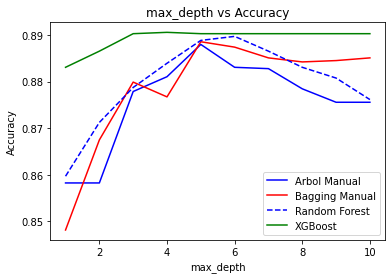

In [40]:
# Celda 8
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, accuracy_scores, color="blue", label="Arbol Manual")
plt.plot(max_depth_range, accuracy_scores_bag, color="red", label="Bagging Manual")
plt.plot(max_depth_range, accuracy_scores_rfd, color='blue', linestyle='--', label="Random Forest")
plt.plot(max_depth_range, accuracy_scores_xg, color="green", label="XGBoost")
plt.title('max_depth vs Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

En la gráfica comparativa se evidencia que el mejor desempeño se obtubo con el modelo XGBoost y el peor desempeño fue el del modelo de Arbol manual.

Del modelo XGBoost se encuentran como ventajas que aprende rápidamente de sus errores y como desventaja tiende a sobreajustarse si no se calibran adecuadamente sus parámetros.

Del modelo de Arbol tenemos como ventaja que es más facil de interpretar sus resultados que los otros modelos vistos y como desventaja tiene una varianza muy alta.